In [1]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendypy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
from scipy.optimize import curve_fit
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%aimport wendym2m
%aimport hom2m
%autoreload 1

# M2M with one-dimensional self-gravity with an external potential taking into account number/mass density ratio, $X_{nm}$ with MCMC sample uncertainty estimates, using the observational constraints of density and $<v^2>$.

# Appying to a perturbed disk

Here we investigate M2M with one-dimensional self-gravity and a constant density background, taking into account number/mass density ratio, which is defined with Xnm. We will apply it to a target 1D disk which is perturbed by a vertical impact, similar to a satellite perturbation. We also add $<v>$ to the observational constraints.

## Mock observations

First we generate some mock observations for a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk) with a constant background. Then, we will perturb the disk with a vertical impact. 

A well-known solution of the one-dimensional N-body system is a $\mathrm{sech}^2$ disk. This is the equilibrium distribution for a disk with an isothermal Gaussian velocity distribution (that is, a velocity distribution that is Gaussian with the same dispersion at all locations). Because the equilibrium distribution can only be a function of the energy $E = \Phi(z)+v^2/2$ and the velocity distribution is required to be Gaussian, $f(v) \propto e^{-v^2/[2\sigma^2]}$, the equilibrium distribution function is by necessity:

$f(z,v) = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-E/\sigma^2} = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-\Phi(z)/\sigma^2-v^2/[2\sigma^2]}\,,$

with density

$\rho(z) = \rho_0\,e^{-\Phi(z)/\sigma^2}\,.$

Plugging this density into the Poisson equation allows us to solve for the potential:

$\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = 4\pi G \rho(z) = 4\pi G \rho_0\,e^{-\Phi(z)/\sigma^2}\,,$

which has the solution

$\Phi(z) = 2\sigma^2 \ln\left(\mathrm{cosh}\left[\frac{z}{2 H}\right]\right)\,,$

with $H^2 = \sigma^2/[8\pi G \rho_0]$, because

$\frac{\mathrm{d}\Phi(z)}{\mathrm{d}z} = \frac{2 \sigma^2}{2 H} \frac{\mathrm{sinh}\left[\frac{z}{2 H}\right]}{\mathrm{cosh}\left[\frac{z}{2 H}\right]} = \frac{2 \sigma^2}{2 H}  \mathrm{tanh}\left[\frac{z}{2 H}\right]$, $\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = \frac{2 \sigma^2}{4 H^2} \mathrm{sech}^2\left[\frac{z}{2 H}\right]$

Alternatively, $H = \sigma^2 / [2\pi G \Sigma]$, where $\Sigma$ is the total surface density. The density is then

$\rho(z) = \rho_0\,\mathrm{sech}^2\left(\frac{z}{2H}\right)\,$

and
 
$\Sigma = \int^{\infty}_{-\infty} \rho_0 \mathrm{sech}^2\left[\frac{z}{2 H}\right] dz = 4 H \rho_0$.

We set $\Sigma=1.0$ and $\sigma=0.5$, and therefore with $2 \pi G=1$ unit, $H=0.25$ and $\rho0=1$. 

For an external potential, we consider that in the solar neighborhood dark matter is an approximately constant density $\rho_{\mathrm{DM}} = $ constant.

This density corresponds to a potential $\Phi_{\mathrm{DM}} = \omega^2 z^2 / 2$, with $\omega = \sqrt{4\pi\,G\,\rho_{\mathrm{DM}}}$.

We set $\rho_{\mathrm{DM}}=1$, i.e. equivalent to the disk mass, and therfore $\omega = 1/\sqrt{2}$. 

We consider that the observed density is number density of stars, but in M2M model, each element's $w$ traces mass. Here, we assume the number and mass denity ratio of $X_{nm}$, and fit it as well.

### First, read the fit results data.

In [5]:
savefilename= 'basic_rhov2obs_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,totmass_true,\
             zh_true,sigma_true,data_dicts,z_mock,vz_mock,v_obs,\
             w_init,h_m2m,omega_m2m,xnm_m2m,zsun_m2m,\
             dens_init,v2_init,v_init,\
             nstep,step,tdyn,eps,Q,wevol,windx = out

print(' Q shape=',numpy.shape(Q))


 Q shape= (10000, 40)


 total mass = 1.0000752816771572


NameError: name 'v_obs_noise' is not defined

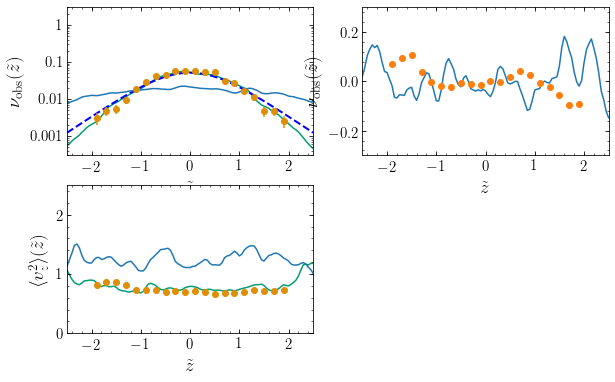

In [6]:
zmin = -2.5
zmax = 2.5
rhomin = 10.**-3.
rhomax = 0.6
nbinz = 101
for jj,data_dict in enumerate(data_dicts):
    if data_dict['type'].lower() == 'dens':
        z_obs = data_dict['zobs']
        dens_obs = data_dict['obs']
        dens_obs_noise = data_dict['unc']
    elif data_dict['type'].lower() == 'v2':
        v2_obs = data_dict['obs']
        v2_obs_noise = data_dict['unc']
# v_obs = data_dicts['type' == 'v']['obs']
# v_obs_noise = data_dicts['type' == 'v']['unc']
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,2.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=constraint_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(zmin, zmax)
ylim(0.,1.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [95]:
import wendym2m
# print(' shape w_init, w_out=', numpy.shape(w_init), numpy.shape(w_out))
step_sam= 0.05*tdyn
# nstep_sam= nstep
nstep_sam = 100
eps_sam= eps
nsamples= 10
s_low, s_high= 16, -16
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.2
omega_m2m= omegadm_true
zsun_m2m= zsun_true
xnm_m2m = xnm_true
prior= 'entropy'
use_v2=True
savefilename= 'basic_sam.sav'
# if os.path.exists(savefilename):
#     with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#else:
out= wendym2m.sample_m2m(nsamples,w_out,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                          data_dicts,
                          nstep=nstep_sam,step=step_sam,eps=eps_sam,
                          mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                          smooth=smooth,st96smooth=st96smooth,
                          number_density=True, xnm_m2m=xnm_m2m)
save_pickles(savefilename,*out)
w_sam,Q_sam,z_sam,vz_sam= out



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

 20%|██        | 2/10 [00:11<00:46,  5.77s/it]

 30%|███       | 3/10 [00:17<00:41,  5.89s/it]

 40%|████      | 4/10 [00:23<00:34,  5.77s/it]

 50%|█████     | 5/10 [00:28<00:28,  5.63s/it]

 60%|██████    | 6/10 [00:33<00:22,  5.51s/it]

 70%|███████   | 7/10 [00:38<00:16,  5.35s/it]

 80%|████████  | 8/10 [00:43<00:10,  5.23s/it]

 90%|█████████ | 9/10 [00:48<00:05,  5.15s/it]

100%|██████████| 10/10 [00:53<00:00,  5.06s/it]

 total mass = 1.0000752816771572
 shape z, vz, w= (10, 4000) (10, 4000) (10, 4000)
/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykerne

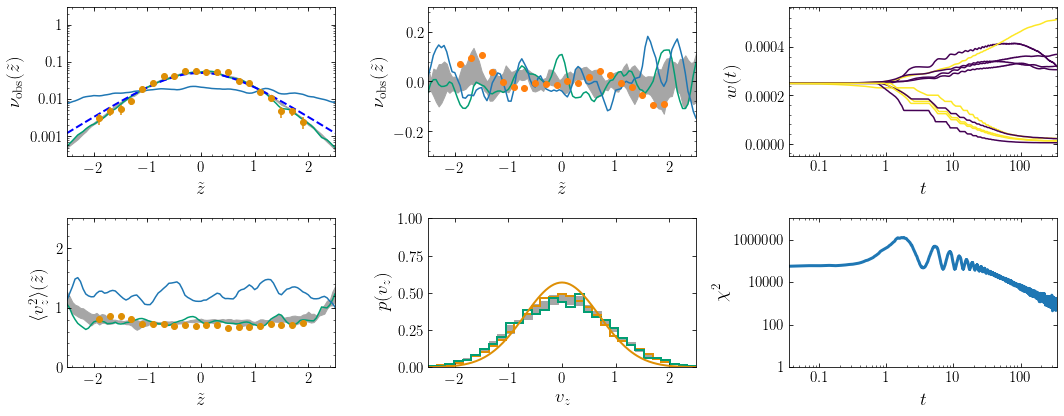

In [96]:
print(' total mass =', numpy.sum(w_out))
# for test
s_low=-2
s_high=2
# pick up first population
w_samallpop = copy.deepcopy(w_sam)
w_sam = copy.deepcopy(w_samallpop[:, :, 0])
print(' shape z, vz, w=', numpy.shape(z_sam), numpy.shape(vz_sam), numpy.shape(w_sam))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
# density and v2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
v_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist = numpy.empty((nsamples,31))
for ii in range(nsamples):
    dens_final_sam[ii]= xnm_m2m*hom2m.compute_dens(z_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v_final_sam[ii]= hom2m.compute_v(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[zmin,zmax])    
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
v_final_sam_sorted= numpy.sort(v_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,2.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
fill_between(z_out, v2_final_sam_sorted[s_low], v2_final_sam_sorted[s_high],color='0.65',zorder=0)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
fill_between(z_out, v_final_sam_sorted[s_low], v_final_sam_sorted[s_high],color='0.65',zorder=0)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,range=(zmin,zmax),zorder=0,color=constraint_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,range=(zmin,zmax),zorder=1,color=final_color)
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(zmin, zmax)
ylim(0.,1.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()
# bring back w_sam
w_sam = copy.deepcopy(w_samallpop)

## Sample $X_{nm}$

Read the fit results data.

In [11]:
savefilename= 'xnmomega_rhov2obs_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,totmass_true,\
         zh_true,sigma_true,data_dicts,z_mock,vz_mock,v_obs,\
         w_init,h_m2m,omega_m2m,xnm_m2m,zsun_m2m,\
         dens_init,v2_init,v_init,\
         nstep,step,tdyn,eps,Q,wevol,windx = out

 total mass = 1.0029679913003253
 omega fit, true =  0.681576730634833 0.7071067811865475
 Xnm fit true =  0.09982749540243173 0.1
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)



NameError: name 'v_obs_noise' is not defined

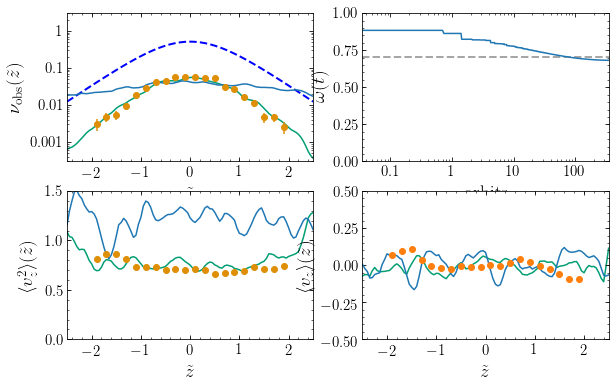

In [12]:
print(' total mass =', numpy.sum(w_out))
print(' omega fit, true = ',omega_out[-1], omegadm_true)
print(' Xnm fit true = ', xnm_out[-1], xnm_true)
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_out[-1]*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,1.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
# omega evolution
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,1.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
axhline(omegadm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(
    FuncFormatter(
        lambda y,pos: 
        (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,5)
# _= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
# xs= numpy.linspace(zmin, zmax, 201)
# plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
#     lw=2.,zorder=2,color=constraint_color)
# _= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
# xlim(zmin, zmax)
# ylim(0.,2.)
# xlabel(r'$v_z$')
# ylabel(r'$p(v_z)$')
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z\rangle(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5,0.5])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,xnm_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,.5],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$X_{nm}(t)$',gcf=True)
axhline(xnm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [127]:
# print(' shape w_init, w_out=', numpy.shape(w_init), numpy.shape(w_out))
step_sam= 0.05*tdyn
# nstep_sam= nstep
nstep_sam = 100
# eps_sam= eps
eps = [10.0**-7.0, 10.0**-8.0, 10.0**-8.0]
nsamples= 10
s_low, s_high= 16, -16
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.2
omega_m2m= omega_out[-1]
zsun_m2m= zsun_true
xnm_m2m = xnm_out[-1]
fit_zsun = False
fit_omega = False
skipomega= 10
skipxnm = 1
fit_xnm = True
sig_xnm = 0.001
prior= 'entropy'
use_v2=True
savefilename= 'basic_sam.sav'
# if os.path.exists(savefilename):
#     with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#else:
out= wendym2m.sample_m2m(nsamples,w_out,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                         data_dicts,
                         nstep=nstep_sam,step=step_sam,eps=eps_sam,
                         mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                         smooth=smooth,st96smooth=st96smooth,
                         fit_omega=fit_omega,skipomega=skipomega,
                         number_density=True, xnm_m2m=xnm_m2m, fit_xnm=fit_xnm, skipxnm=skipxnm,
                         sig_xnm=sig_xnm)
save_pickles(savefilename,*out)
w_sam,xnm_sam, Q_sam,z_sam,vz_sam= out






  0%|          | 0/10 [00:00<?, ?it/s]




 10%|█         | 1/10 [01:25<12:46, 85.22s/it]




 20%|██        | 2/10 [03:09<12:06, 90.82s/it]




 30%|███       | 3/10 [04:49<10:56, 93.74s/it]




 40%|████      | 4/10 [06:26<09:28, 94.74s/it]




 50%|█████     | 5/10 [08:08<08:04, 96.87s/it]




 60%|██████    | 6/10 [09:46<06:29, 97.28s/it]




 70%|███████   | 7/10 [11:20<04:48, 96.31s/it]




 80%|████████  | 8/10 [12:58<03:13, 96.64s/it]




 90%|█████████ | 9/10 [14:39<01:38, 98.15s/it]




100%|██████████| 10/10 [16:10<00:00, 95.79s/it]

MH acceptance ratio for xnm was 0.41


 total mass = 1.0029679913003253
xnm: best-fit, mean of samples unc.) 0.09982749540243173 0.13120945821482904 0.019269168338893146
 shape z, vz, w= (10, 4000) (10, 4000) (10, 4000)
 z sam= [[ 2.02161694 -0.2105725   1.21375798 ...  1.60553523  3.73025195
   0.96725549]
 [-2.20269937 -1.8374993   1.56717498 ... -0.35249865 -1.12795433
   1.24983888]
 [-2.27700661 -0.04753473 -1.03525969 ... -1.85433988 -4.40344792
  -1.76998662]
 ...
 [ 0.48779397  0.38655128 -0.75937426 ... -3.43936678 -0.24847972
   1.68565803]
 [ 1.94826355 -1.36526728 -1.03613975 ...  3.99845293 -3.17005695
   2.42364893]
 [-0.11102257  1.15695225 -1.45507718 ... -2.54170225 -4.36475535
   1.29879207]]
/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when d

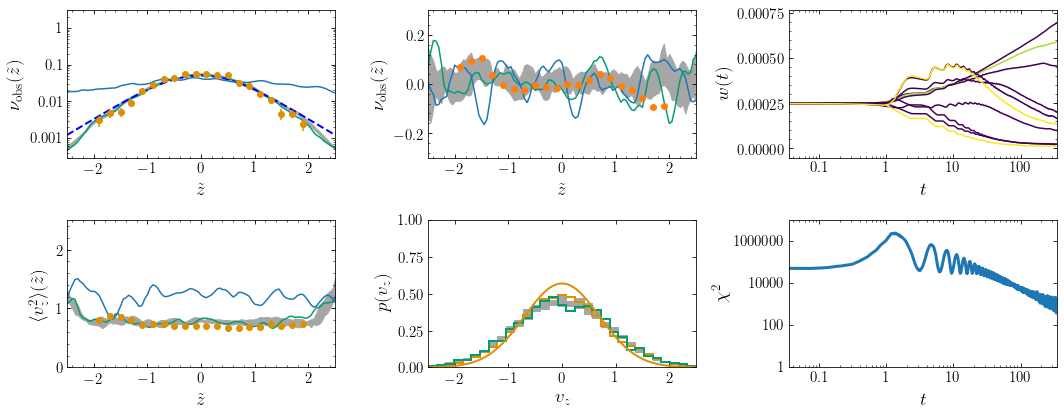

In [128]:
print(' total mass =', numpy.sum(w_out))
# for test
s_low=-2
s_high=2
#
print("xnm: best-fit, mean of samples unc.)",xnm_out[-1],numpy.mean(xnm_sam),numpy.std(xnm_sam))
xnm_m2m = xnm_out[-1]
# pick up first population
w_samallpop = copy.deepcopy(w_sam)
w_sam = copy.deepcopy(w_samallpop[:, :, 0])
print(' shape z, vz, w=', numpy.shape(z_sam), numpy.shape(vz_sam), numpy.shape(w_sam))
print(' z sam=',z_sam)
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
# density and v2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
v_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist = numpy.empty((nsamples,31))
for ii in range(nsamples):
    dens_final_sam[ii]= xnm_m2m*hom2m.compute_dens(z_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v_final_sam[ii]= hom2m.compute_v(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[zmin,zmax])    
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
v_final_sam_sorted= numpy.sort(v_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,2.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
fill_between(z_out, v2_final_sam_sorted[s_low], v2_final_sam_sorted[s_high],color='0.65',zorder=0)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
fill_between(z_out, v_final_sam_sorted[s_low], v_final_sam_sorted[s_high],color='0.65',zorder=0)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,range=(zmin,zmax),zorder=0,color=constraint_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,range=(zmin,zmax),zorder=1,color=final_color)
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(zmin, zmax)
ylim(0.,1.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()
# bring back w_sam
w_sam = copy.deepcopy(w_samallpop)

## Sample both $\omega$ and $X_{nm}$

In [9]:
savefilename= 'xnmomega_rhov2obs_data.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,totmass_true,\
         zh_true,sigma_true,data_dicts,z_mock,vz_mock,v_obs,\
         w_init,h_m2m,omega_m2m,xnm_m2m,zsun_m2m,\
         dens_init,v2_init,v_init,\
         nstep,step,tdyn,eps,Q,wevol,windx = out

 total mass = 1.0029679913003253
 omega fit, true =  0.681576730634833 0.7071067811865475
 Xnm fit true =  0.09982749540243173 0.1
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

Velocity dispersions: mock, fit 0.8401480585310649 0.8773887858301116
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)



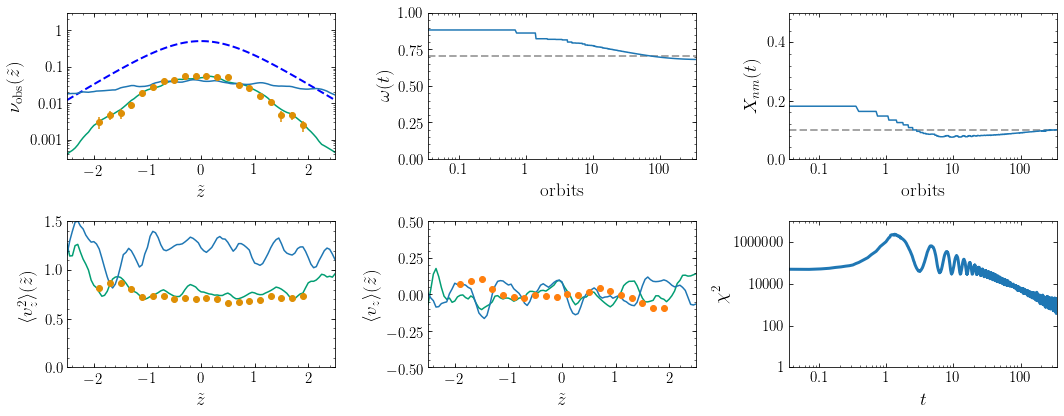

In [18]:
print(' total mass =', numpy.sum(w_out))
print(' omega fit, true = ',omega_out[-1], omegadm_true)
print(' Xnm fit true = ', xnm_out[-1], xnm_true)
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_out[-1]*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,1.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
# omega evolution
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,1.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
axhline(omegadm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(
    FuncFormatter(
        lambda y,pos: 
        (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,5)
# _= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
# xs= numpy.linspace(zmin, zmax, 201)
# plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
#     lw=2.,zorder=2,color=constraint_color)
# _= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
# xlim(zmin, zmax)
# ylim(0.,2.)
# xlabel(r'$v_z$')
# ylabel(r'$p(v_z)$')
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z\rangle(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5,0.5])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
#errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,xnm_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,.5],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$X_{nm}(t)$',gcf=True)
axhline(xnm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [19]:
# print(' shape w_init, w_out=', numpy.shape(w_init), numpy.shape(w_out))
step_sam= 0.05*tdyn
# nstep_sam= nstep
nstep_sam = 100
# eps_sam= eps
eps = [10.0**-7.0, 10.0**-8.0, 10.0**-8.0]
# used for weight sampling only
eps_sam = eps[0]
nsamples= 10
s_low, s_high= 16, -16
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.2
omega_m2m= omega_out[-1]
zsun_m2m= zsun_true
xnm_m2m = xnm_out[-1]
fit_zsun = False
fit_omega = True
sig_omega = 0.001
nmh_omega = 10
fit_xnm = True
sig_xnm = 0.001
nmh_xnm = 10
prior= 'entropy'
use_v2=True
# these will not be used
skipomega= 20
skipxnm = 10
savefilename= 'basic_sam.sav'
# if os.path.exists(savefilename):
#     with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#else:
out= wendym2m.sample_m2m(nsamples,w_out,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                         data_dicts,
                         nstep=nstep_sam,step=step_sam,eps=eps_sam,
                         mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                         smooth=smooth,st96smooth=st96smooth,
                         fit_omega=fit_omega, sig_omega=sig_omega, nmh_omega=nmh_omega, skipomega=skipomega,
                         number_density=True, xnm_m2m=xnm_m2m, fit_xnm=fit_xnm, skipxnm=skipxnm,
                         sig_xnm=sig_xnm, nmh_xnm=nmh_xnm)
save_pickles(savefilename,*out)
w_sam,xnm_sam, omega_sam, Q_sam,z_sam,vz_sam= out



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:57<17:33, 117.01s/it]

 20%|██        | 2/10 [03:50<15:26, 115.84s/it]

 30%|███       | 3/10 [05:43<13:26, 115.22s/it]

 40%|████      | 4/10 [07:43<11:38, 116.46s/it]

 50%|█████     | 5/10 [09:41<09:45, 117.00s/it]

 60%|██████    | 6/10 [11:36<07:45, 116.33s/it]

 70%|███████   | 7/10 [13:33<05:49, 116.48s/it]

 80%|████████  | 8/10 [15:31<03:53, 116.95s/it]

 90%|█████████ | 9/10 [17:28<01:57, 117.04s/it]

100%|██████████| 10/10 [19:23<00:00, 116.37s/it]

MH acceptance ratio for xnm was 0.45
MH acceptance ratio for omega was 0.07


 total mass = 1.0029679913003253
xnm: best-fit, mean of samples unc.) 0.09982749540243173 0.11677681060976045 0.010760379487979555
omega: best-fit, mean of samples unc.) 0.681576730634833 0.680158857716062 0.0018420352145160428
 shape z, vz, w= (10, 4000) (10, 4000) (10, 4000)
 z sam= [[-1.66964234  0.17969059  0.866804   ... -2.37027078  4.50398621
   2.29093867]
 [-1.0994443  -1.92952001 -0.32657843 ... -3.7033059   4.35497355
   1.58550904]
 [ 0.03914945 -1.96347838 -0.62666504 ... -2.86001834 -4.4004737
  -1.30691746]
 ...
 [-0.04005166 -0.1823594  -0.94295817 ...  3.10239186 -3.00615913
   0.08100904]
 [-0.49493457 -1.28606363  0.38448523 ... -0.85702913  2.19337062
  -1.72502898]
 [-0.3599453  -0.68523132  0.76937617 ... -3.18847555 -1.28382639
  -0.91955586]]
/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density functi

NameError: name 'v_obs_noise' is not defined

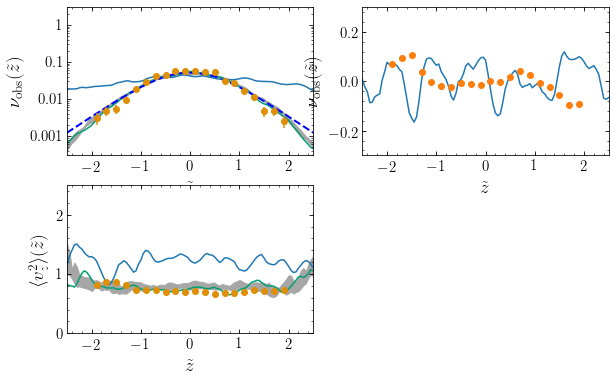

In [20]:
print(' total mass =', numpy.sum(w_out))
# for test
s_low=-2
s_high=2
#
print("xnm: best-fit, mean of samples unc.)",xnm_out[-1],numpy.mean(xnm_sam),numpy.std(xnm_sam))
xnm_m2m = xnm_out[-1]
print("omega: best-fit, mean of samples unc.)",omega_out[-1],numpy.mean(omega_sam),numpy.std(omega_sam))
omega_m2m = omega_out[-1]
# pick up first population
w_samallpop = copy.deepcopy(w_sam)
w_sam = copy.deepcopy(w_samallpop[:, :, 0])
print(' shape z, vz, w=', numpy.shape(z_sam), numpy.shape(vz_sam), numpy.shape(w_sam))
print(' z sam=',z_sam)
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
# density and v2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
v_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist = numpy.empty((nsamples,31))
for ii in range(nsamples):
    dens_final_sam[ii]= xnm_m2m*hom2m.compute_dens(z_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    v_final_sam[ii]= hom2m.compute_v(z_sam[ii],vz_sam[ii],zsun_true,z_out,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii],weights=w_sam[ii],normed=True,bins=31,range=[zmin,zmax])    
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
v_final_sam_sorted= numpy.sort(v_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[xnm_true*0.003,xnm_true*30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'-',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[0.0,2.5],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
fill_between(z_out, v2_final_sam_sorted[s_low], v2_final_sam_sorted[s_high],color='0.65',zorder=0)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.3,0.3])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
fill_between(z_out, v_final_sam_sorted[s_low], v_final_sam_sorted[s_high],color='0.65',zorder=0)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,range=(zmin,zmax),zorder=0,color=constraint_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
h,e,p= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,range=(zmin,zmax),zorder=1,color=final_color)
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(zmin, zmax)
ylim(0.,1.)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()
# bring back w_sam
w_sam = copy.deepcopy(w_samallpop)